In [178]:
from collections import Counter
from linearmodels.panel import PanelOLS
from scipy.stats import pearsonr
from functools import reduce
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os
import re
import io


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [77]:
data_dir = "../../../Downloads/dhs_data/"
files = [f for f in os.listdir(data_dir) if ".dta" in f]
dataframes = {}
for f in files:
    dataframes[int(f[3:7])] = pd.read_stata(data_dir+f)
years = sorted(dataframes.keys())

In [78]:
original_columns = ['nohhold', 'nomem', 'gez3', 'ij16br']
rename_map = {'gez3': 'health', 'ij16br': 'income'}
id_columns = ['nohhold', 'nomem']

In [81]:
# Load and process each DataFrame
dfs = []
for f in files:
    year = int(f[3:7])
    df = pd.read_stata(os.path.join(data_dir, f))

    # Map lowercase column names to actual names in the DataFrame
    col_map = {col.lower(): col for col in df.columns}

    # Match needed columns (case-insensitive)
    matched = {col: col_map[col.lower()] for col in original_columns if col.lower() in col_map}
    if not all(col in matched for col in id_columns):
        continue  # skip if key ID columns aren't present

    # Extract and rename columns
    id_cols = [matched[col] for col in id_columns]
    value_cols = [matched[col] for col in matched if col not in id_columns]

    # Create rename mapping with year
    renamed = {
        matched[col]: f"{rename_map[col]}_{year}"
        for col in matched
        if col in rename_map
    }

    sub_df = df[id_cols + value_cols].copy()
    sub_df.rename(columns=renamed, inplace=True)
    sub_df.drop_duplicates(subset=id_cols, inplace=True)

    dfs.append(sub_df)

# Merge all on household and member ID
merged_df = reduce(
    lambda left, right: pd.merge(left, right, on=id_columns, how='outer'),
    dfs
)

merged_df.head()

,nohhold,nomem,health_2023,income_2023,health_2017,income_2017,health_2005,income_2005,health_2011,income_2011,...,health_2015,income_2015,health_2014,income_2014,health_2020,income_2020,health_2006,income_2006,health_2013,income_2013
0,6.0,1.0,Good,NaN,Good,NaN,good,NaN,good,NaN,...,Fair,NaN,good,NaN,Good,NaN,not so good,NaN,good,NaN
1,6.0,2.0,NaN,NaN,NaN,NaN,good,NaN,good,NaN,...,Good,NaN,fair,NaN,NaN,NaN,fair,NaN,fair,NaN
2,21.0,1.0,NaN,NaN,Good,NaN,good,NaN,good,NaN,...,Good,NaN,good,NaN,NaN,NaN,good,NaN,good,NaN
3,21.0,2.0,NaN,NaN,NaN,NaN,excellent,NaN,excellent,NaN,...,Good,NaN,good,NaN,NaN,NaN,excellent,NaN,good,NaN
4,21.0,3.0,NaN,NaN,NaN,NaN,excellent,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
health_mapping = {
    'excellent': 5,
    'good': 4,
    'fair': 3,
    'not so good': 2,
    'poor': 1
}

health_cols = [col for col in merged_df.columns if 'health' in col.lower()]
for col in health_cols:
    merged_df[col] = merged_df[col].astype(str).str.lower().map(health_mapping)

In [83]:
def map_income_to_median(income_series: pd.Series) -> pd.Series:
    """
    Replaces income range categories with their median numeric value.
    
    This function is fully idempotent and robust:
    1. If the entire column is already numeric, it's returned immediately.
    2. If it processes categories, it checks if a category is already a number
       and preserves it, preventing erroneous NaN conversion.
    3. It correctly handles single-number categories without keywords.
    """
    # 1. High-level check: If the entire column is numeric, do nothing.
    if pd.api.types.is_numeric_dtype(income_series.dtype):
        return income_series
        
    # Get unique categories to build the mapping.
    # Using dropna().unique() is safe for both 'category' and 'object' dtypes.
    categories = income_series.dropna().unique()
    mapping_dict = {}

    for cat in categories:
        # 2. Per-category check: If the category is already a number, map it to itself.
        if isinstance(cat, (int, float)):
            mapping_dict[cat] = cat
            continue

        s_lower = str(cat).lower()

        # 3. Handle "Don't know"
        if "don't know" in s_lower or "dont know" in s_lower or "don t know" in s_lower:
            mapping_dict[cat] = np.nan
            continue

        # 4. Clean the string and extract all numbers
        s_cleaned = s_lower.replace(',', '').replace('.', '')
        numbers = re.findall(r'\d+', s_cleaned)
        
        # If no numbers found (e.g., "Refused to answer"), map to NaN
        if not numbers:
            mapping_dict[cat] = np.nan
            continue
            
        nums = [int(n) for n in numbers]

        # 5. The corrected mapping logic
        if len(nums) == 2:
            # Case: A range like '8000 - 16000' -> 12000
            value = (nums[0] + nums[1]) / 2
        elif len(nums) == 1:
            if any(keyword in s_lower for keyword in ['up until', 'until', 'less than', 'under', 'to']):
                # 'Up until 8,000' -> 4000
                value = nums[0] / 2
            elif any(keyword in s_lower for keyword in ['or more', 'over', 'above', 'plus']):
                # '60,000 or more' -> 60000
                value = nums[0]
            else:
                value = nums[0]
        else:
            # Case: Too many numbers found, ambiguous.
            value = np.nan

        if value < 10:
            value = 8000
        
        mapping_dict[cat] = value

    return income_series.map(mapping_dict)

In [84]:
for col in merged_df.columns:
    if 'income' in col.lower():
        merged_df[col] = map_income_to_median(merged_df[col])

In [85]:
merged_df['person_id'] = merged_df['nohhold'].astype(str) + '_' + merged_df['nomem'].astype(str)

df_long = pd.wide_to_long(merged_df, 
                          stubnames=['health', 'income'], 
                          i='person_id', 
                          j='year',
                          sep='_').reset_index()

df_long = df_long.sort_values(['person_id', 'year'])
df_long = df_long.dropna(subset=['health', 'income'])

In [86]:
def income_map(x):
    if x <= 12000:
        return 1
    elif x <= 30000:
        return 2
    elif x == 42000:
        return 3
    elif x == 54000:
        return 4
    else:
        return 5

df_long["income"] = df_long["income"].map(lambda x: income_map(x))

In [170]:
result_suffix = "5"
result_dir = "results_" + result_suffix

with open(f"alternate_minima_{result_suffix}.pickle", "rb") as f:
    MINIMA = pickle.load(f)

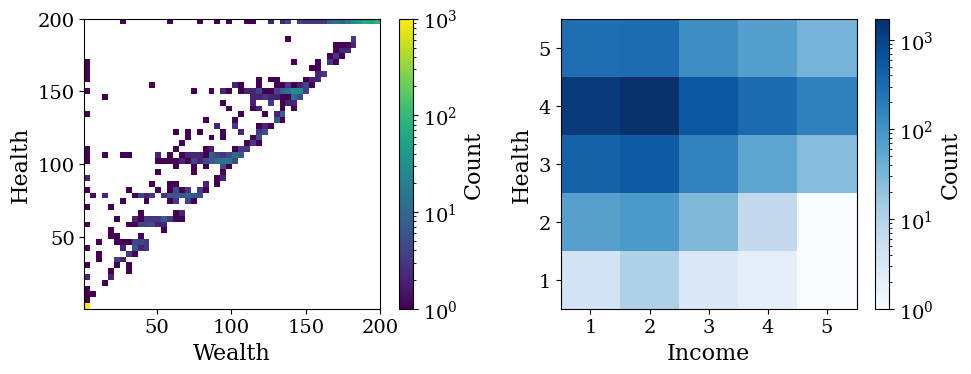

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

minima_locations = []
for m in MINIMA:
    for point in m[1]:
        minima_locations.append(point[0])
hist = axs[0].hist2d(
    [x[0] for x in minima_locations],
    [x[1] for x in minima_locations],
    bins=50,
    norm="log"
)
cbar = plt.colorbar(hist[3], label="Count", ax=axs[0])
cbar.set_ticks([1, 10, 100, 1000])

axs[0].set_xlabel("Wealth")
axs[0].set_ylabel("Health")



bin_centers = [1.5, 2.5, 3.5, 4.5, 5.5]
bin_labels = [1, 2, 3, 4, 5]

# Use a range to make sure the bins align as we expect
h = axs[1].hist2d(df_long["income"], df_long["health"], bins=5, range=[[1, 6], [1, 6]], cmap='Blues', norm="log")

fig.colorbar(h[3], ax=axs[1], label='Count')

# axs[1].colorbar(label='Count')
axs[1].set_xlabel('Income')
axs[1].set_ylabel('Health')

# Set the ticks at the calculated centers, with the desired labels
axs[1].set_yticks(ticks=bin_centers, labels=bin_labels)
axs[1].set_xticks(ticks=bin_centers, labels=bin_labels)

fig.tight_layout()
plt.savefig("minima.pdf", bbox_inches="tight")
plt.show()

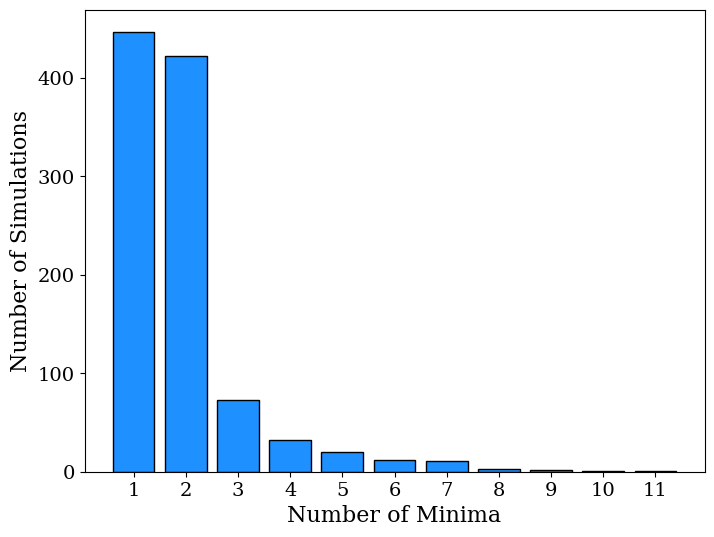

In [181]:
asdf = dict(Counter([len(x[1]) for x in MINIMA]))
num_min = []
for k in range(1,max(asdf)+1):
    num_min.append(asdf[k])
plt.bar(
    np.arange(1,12),
    num_min,
    color="dodgerblue",
    edgecolor="k",
)

plt.xticks(np.arange(1,12))
plt.xlabel("Number of Minima")
plt.ylabel("Number of Simulations")
plt.savefig("num_minima_hist.pdf", bbox_inches="tight")
plt.show()

In [156]:
def plot_colored_line(ax, x, y, cmap='viridis'):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, len(x) - 1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.arange(len(x) - 1))
    lc.set_linewidth(2)
    lc.set_alpha(0.7)
    ax.add_collection(lc)
    ax.autoscale()
    return lc

  0%|          | 0/2780 [00:00<?, ?it/s]

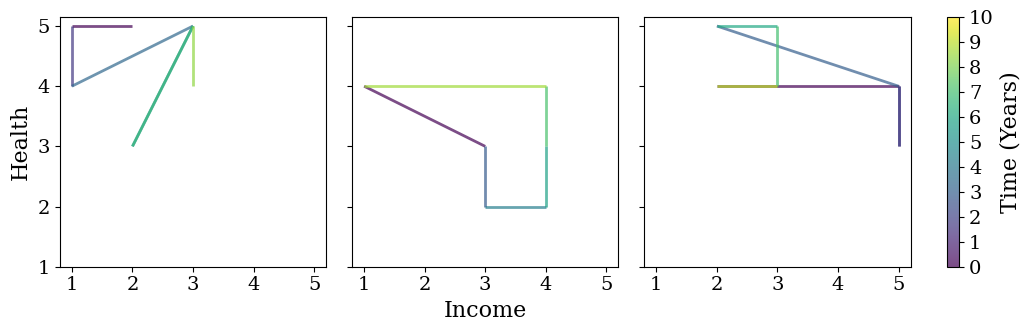

In [218]:
fig, axs = plt.subplots(1, 3, figsize=(10,3.5), sharex=True, sharey=True)
count = 0
lc = None 

for name, g in tqdm(df_long.groupby("person_id")):
    if name not in ["19962.0_3.0", "59235.0_1.0", "74435.0_1.0"]:
        continue
    income = np.array(g["income"])
    health = np.array(g["health"])
    lc = plot_colored_line(axs[count], income, health)
    axs[count].set_xticks([1,2,3,4,5])
    axs[count].set_yticks([1,2,3,4,5])
    axs[count].set_xlim(0.8,5.2)

    # plot_colored_line(axs[count], health, income)
    count+=1

axs[1].set_xlabel("Income")
axs[0].set_ylabel("Health")

fig.tight_layout()

cbar = fig.colorbar(lc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Time (Years)')
cbar.locator = ticker.MaxNLocator(integer=True)
cbar.update_ticks()

plt.savefig("empirical_cycles.pdf", bbox_inches="tight")
plt.show()